# Forecasting Daily Stock Returns: A Data Science Project

## 1. Research Question and Context

The goal of this project is to forecast **daily stock returns** for a chosen publicly listed company using historical data. A clear research question might be: *“Can we predict tomorrow’s return of \[Stock X] using 10 years of past price data and advanced time series models?”* Stock markets are notoriously volatile, and making accurate short-term predictions is challenging. We will compare several models—statistical (ARIMA/GARCH), machine-learning (LSTM), and hybrid (Facebook Prophet)—to see which best captures patterns in the data. By combining these forecasts in an ensemble, we aim to leverage their complementary strengths. Our evaluation will focus on prediction error metrics (RMSE, MAPE) to judge performance.

## 2. Data Extraction with yfinance

We use the `yfinance` Python package to download 10 years of daily price data. For example, to analyze Apple Inc. (ticker **AAPL**):

In [13]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from scipy.stats import skew, kurtosis, normaltest
from statsmodels.tsa.seasonal import STL
import warnings
warnings.filterwarnings("ignore")

# Download AMZN price data
return_name = "AMZN"
data = yf.download(return_name, start="2013-01-01", end="2023-01-01")[['Close']]
data['Return'] = data['Close'].pct_change() * 100
data = data.dropna()

[*********************100%***********************]  1 of 1 completed


In [5]:
data.head()

Price,Close,Return
Ticker,AMZN,
Date,,
2013-01-03,12.9240,0.454699
2013-01-04,12.9575,0.259213
2013-01-07,13.4230,3.592513
2013-01-08,13.3190,-0.774790
2013-01-09,13.3175,-0.011263


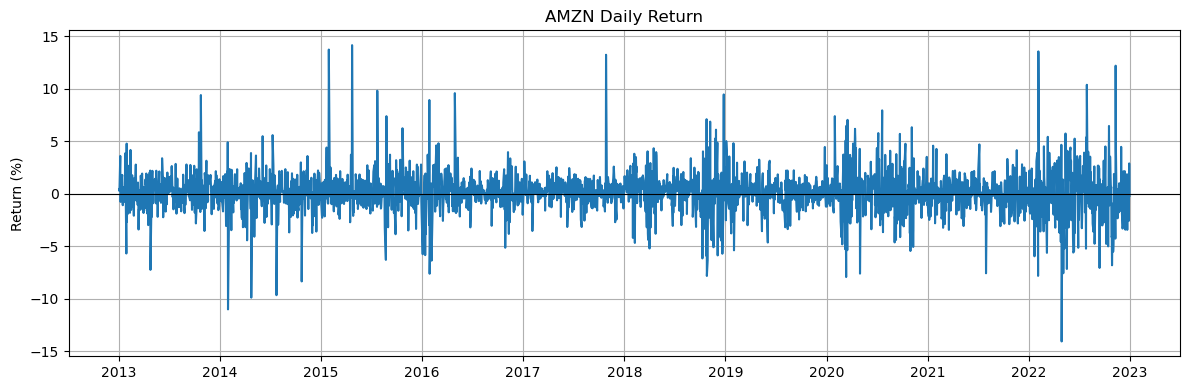

In [15]:
# -----------------------------
# 1. Plot Return Time Series
# -----------------------------
plt.figure(figsize=(12, 4))
plt.plot(data.index, data['Return'], label='Daily Return')
plt.axhline(0, color='black', lw=0.8)
plt.title(f'{return_name} Daily Return')
plt.ylabel("Return (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

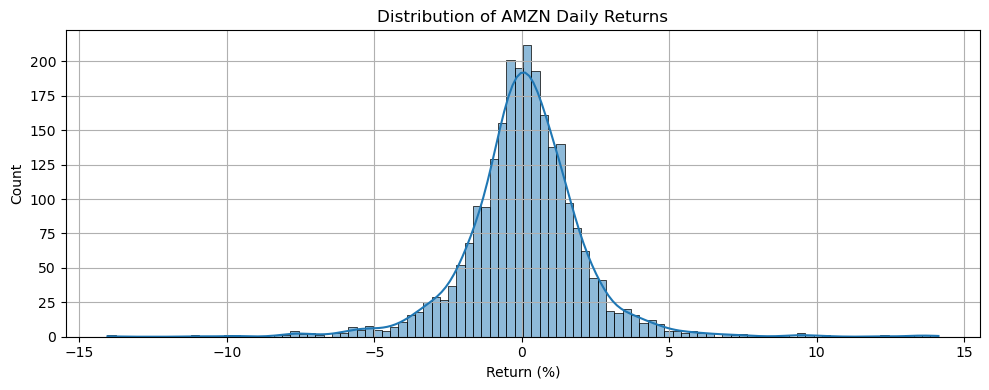

In [17]:
# -----------------------------
# 2. Histogram and Distribution
# -----------------------------
plt.figure(figsize=(10, 4))
sns.histplot(data['Return'], bins=100, kde=True)
plt.title(f'Distribution of {return_name} Daily Returns')
plt.xlabel("Return (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

In [19]:
# Stats
print("Mean:", data['Return'].mean())
print("Std Dev:", data['Return'].std())
print("Skewness:", skew(data['Return']))
print("Kurtosis:", kurtosis(data['Return']))
stat, p = normaltest(data['Return'])
print("Normality test p-value:", p)

Mean: 0.09560766639494436
Std Dev: 2.0542940413434967
Skewness: 0.2661589701696782
Kurtosis: 6.849903219358815
Normality test p-value: 3.0100540754939317e-84


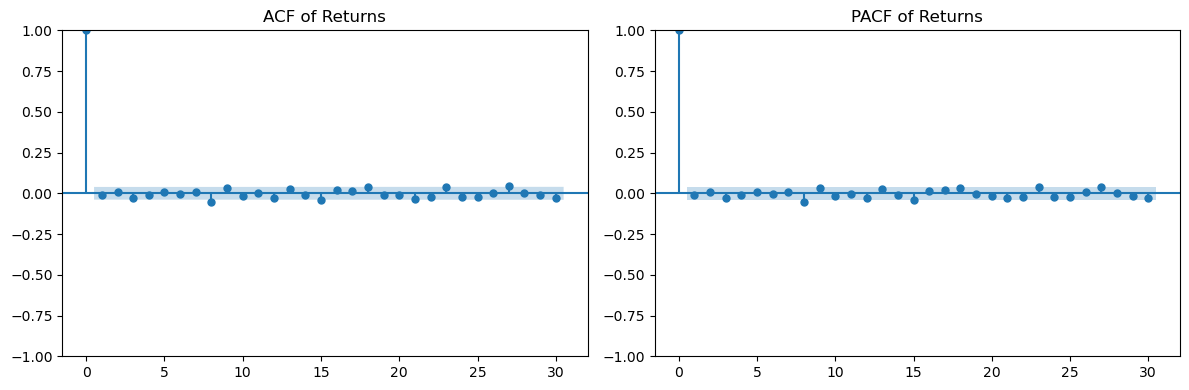

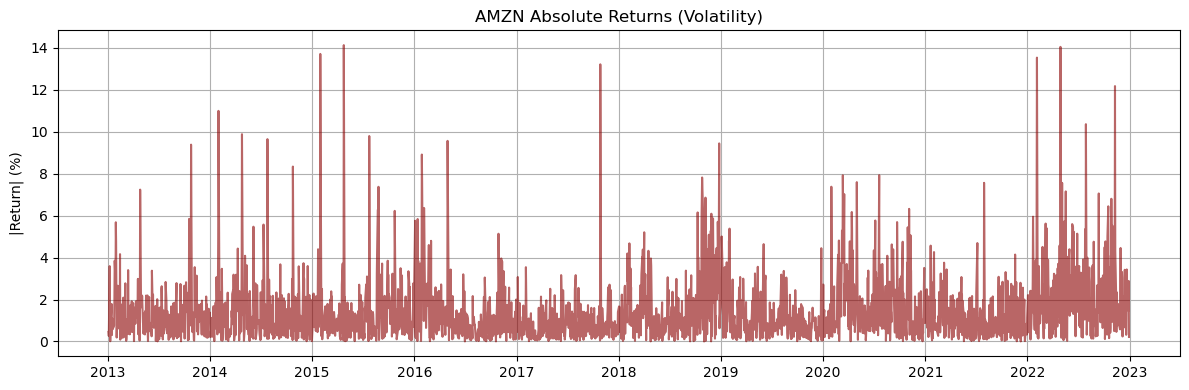

ADF Statistic: -50.81194712915445
p-value: 0.0
Critical Value (1%): -3.4329517425474014
Critical Value (5%): -2.862689439250822
Critical Value (10%): -2.5673818904827863


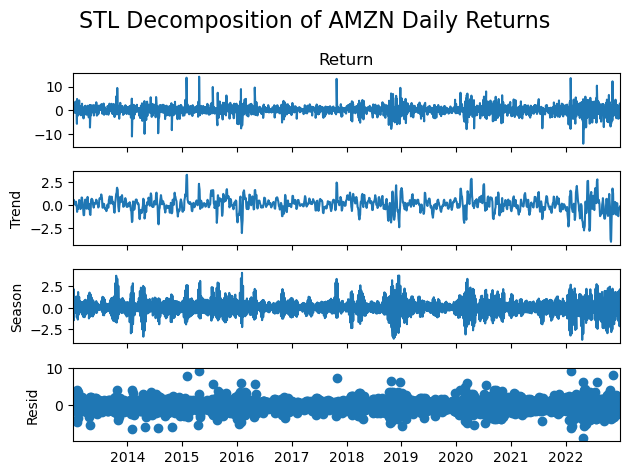

In [21]:
# -----------------------------
# 3. Autocorrelation
# -----------------------------
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(data['Return'], ax=axes[0], lags=30)
plot_pacf(data['Return'], ax=axes[1], lags=30)
axes[0].set_title("ACF of Returns")
axes[1].set_title("PACF of Returns")
plt.tight_layout()
plt.show()

# -----------------------------
# 4. Volatility Clustering
# -----------------------------
plt.figure(figsize=(12, 4))
plt.plot(data.index, data['Return'].abs(), color='darkred', alpha=0.6)
plt.title(f'{return_name} Absolute Returns (Volatility)')
plt.ylabel("|Return| (%)")
plt.grid(True)
plt.tight_layout()
plt.show()

from statsmodels.tsa.stattools import adfuller

adf_result = adfuller(data['Return'])

print("ADF Statistic:", adf_result[0])
print("p-value:", adf_result[1])
for key, value in adf_result[4].items():
    print(f"Critical Value ({key}): {value}")

# -----------------------------
# 5: STL decomposition
# -----------------------------

# STL assumes equally spaced time series, so ensure datetime index is correct
returns_series = data['Return']
stl = STL(returns_series, period=5)  # Weekly seasonality (5 trading days)
result = stl.fit()

# Step 3: Plot the decomposition
fig = result.plot()
fig.suptitle(f"STL Decomposition of {return_name} Daily Returns", fontsize=16)
plt.tight_layout()
plt.show()

 **Summary of AMZN Return EDA**
| Property                   | Observation                         | Implication                                             |
| -------------------------- | ----------------------------------- | ------------------------------------------------------- |
| **Mean**                   | \~0.096%                            | Slight average return                                   |
| **Volatility (Std. Dev.)** | \~2.05%                             | Moderate daily fluctuation                              |
| **Skewness**               | 0.27 (positive)                     | Slight right skew                                       |
| **Kurtosis**               | 6.85                                | Heavy tails, frequent large returns (leptokurtic)       |
| **Normality Test p-val**   | 3.01e-84                            | Reject normality (non-Gaussian distribution)            |
| **ADF p-value**            | 0.0                                 | Reject unit root — returns are stationary               |
| **ACF / PACF**             | No strong lags beyond lag 0         | Low autocorrelation in mean — ARIMA not very predictive |
| **Volatility Clustering**  | Evident (from absolute return plot) | GARCH-style modeling is appropriate                     |


This fetches historical adjusted closing prices (adjusted for splits/dividends). We then sort by date and ensure no missing values:

In [4]:
data = data.sort_index().asfreq('B')  # Business-day frequency
data = data.fillna(method='ffill')   # Forward-fill any gaps
data.head()

Price,Close,Return
Ticker,AMZN,
Date,,
2013-01-03,12.9240,0.454699
2013-01-04,12.9575,0.259213
2013-01-07,13.4230,3.592513
2013-01-08,13.3190,-0.774790
2013-01-09,13.3175,-0.011263


The resulting DataFrame has 10 years (\~2520 trading days) of daily prices.

## 3. Exploratory Data Analysis (EDA)

We begin by visualizing and summarizing the data:

* **Trend Analysis:** Plotting the adjusted closing price over time reveals long-term trends and major events (e.g., crashes or rallies). For instance, we might observe a sharp drop around March 2020 (COVID-19 market crash) followed by a strong recovery.
* **Returns Calculation:** Compute daily returns (percentage change) as the target variable:

  

* **Volatility (Risk):** Calculate rolling volatility (e.g., 21-day standard deviation of returns). Volatility quantifies price fluctuations over time. For example:

In [6]:
  data['Volatility_21d'] = data['Return'].rolling(window=21).std()
  data.iloc[18:24]

Price,Close,Return,Volatility_21d
Ticker,AMZN,,
Date,,,
2013-01-29,13.0175,-5.683960,NaN
2013-01-30,13.6380,4.766657,NaN
2013-01-31,13.2750,-2.661680,2.338930
2013-02-01,13.2500,-0.188321,2.339697
2013-02-04,12.9990,-1.894343,2.382562
2013-02-05,13.3445,2.657897,2.321440


* **Distribution of Returns:** Plot a histogram of daily returns. Financial returns often exhibit a leptokurtic (fat-tailed) distribution. We may compute summary statistics (mean, variance, skewness, kurtosis) to characterize it.
* **Autocorrelation:** Check the autocorrelation function (ACF) of returns. Many financial time series have low autocorrelation in raw returns, but examining ACF can reveal short-term dependencies. In Python, one can use `statsmodels.graphics.tsaplots.plot_acf(data['Return'].dropna(), lags=20)` to visualize this.
* **Summary:** We note key findings, such as whether returns have any persistent autocorrelation or whether volatility clusters. This EDA helps inform model assumptions (e.g., whether to difference data for stationarity, or include volatility modeling).

## 4. Feature Engineering

We create additional predictor variables from the price data:

* **Lagged Returns:** Include previous-day returns as features if useful (simple auto-regressive input).
* **Moving Averages:** Compute moving averages of price or returns (e.g., 7-day and 21-day moving averages) to capture short-term trends:

In [8]:
data['MA_7'] = data['Close'].rolling(window=7).mean()
data['MA_21'] = data['Close'].rolling(window=21).mean()
data.iloc[18:28]

Price,Close,Return,Volatility_21d,MA_7,MA_21
Ticker,AMZN,,,,
Date,,,,,
2013-01-29,13.0175,-5.683960,NaN,13.601857,NaN
2013-01-30,13.6380,4.766657,NaN,13.606429,NaN
2013-01-31,13.2750,-2.661680,2.338930,13.572929,13.454238
2013-02-01,13.2500,-0.188321,2.339697,13.550714,13.469762
2013-02-04,12.9990,-1.894343,2.382562,13.454428,13.471738
2013-02-05,13.3445,2.657897,2.321440,13.332285,13.468000
2013-02-06,13.1110,-1.749781,2.347868,13.233571,13.458095
2013-02-07,13.0115,-0.758902,2.353394,13.232714,13.443524


* **Volatility Features:** Besides the 21-day rolling std computed above, we might include an exponentially weighted volatility to capture more recent volatility.
* **Fundamentals (Optional):** If needed, yfinance can fetch basic fundamentals (e.g., P/E ratio) or macro variables (e.g., interest rates from a public source). For simplicity, this project focuses on price-based features.

All engineered features are aligned so that at time *t*, they use only information from *t-1* and earlier, avoiding lookahead bias. We then drop initial `NaN` values from rolling calculations. The final dataset is split into training (e.g., first 8 years) and testing (last 2 years) for evaluation.

**Column Interpretation**
| Column              | Meaning                                                                                                  |
| ------------------- | -------------------------------------------------------------------------------------------------------- |
| **Close**           | The adjusted closing price of AMZN stock.                                                                |
| **Return**          | Daily return in percentage: $(P_t - P_{t-1}) / P_{t-1} * 100$. Negative and positive swings are visible. |
| **Volatility\_21d** | 21-day rolling standard deviation of returns – a common proxy for recent historical volatility.          |
| **MA\_7**           | 7-day moving average of the closing price – short-term trend signal.                                     |
| **MA\_21**          | 21-day moving average – longer-term trend indicator.                                                     |


## 5. Model Implementation

We implement four forecasting approaches:

### **1. ARIMA (AutoRegressive Integrated Moving Average):**

**Model Purpose:**
Captures linear relationships in univariate time series data. Best suited for data that is stationary (constant mean and variance over time).

**Model Notation:**
ARIMA(p, d, q), where:

* **p** = number of autoregressive (AR) terms
* **d** = number of differencing operations to induce stationarity
* **q** = number of moving average (MA) terms

**Mathematical Form:**
Let $y_t$ be the value of the time series at time $t$. An ARIMA(p,d,q) model is:

$$
\phi(B)(1 - B)^d y_t = \theta(B) \varepsilon_t
$$

Where:

* $B$ is the backshift operator ($B y_t = y_{t-1}$ or $B^d y_t = y_{t-d}$)
* $\phi(B)$ is the AR polynomial: $\phi(B) = 1 - \phi_1 B - \ldots - \phi_p B^p$
* $\theta(B)$ is the MA polynomial: $\theta(B) = 1 + \theta_1 B + \ldots + \theta_q B^q$
* $\varepsilon_t$ is white noise

**Assumptions:**

* Linearity
* Stationarity (after differencing if $d > 0$)
* Residuals are uncorrelated and normally distributed


Performing stepwise search to minimize aic
 ARIMA(0,0,0)(0,0,0)[5] intercept   : AIC=8632.736, Time=0.06 sec
 ARIMA(1,0,0)(1,0,0)[5] intercept   : AIC=8636.355, Time=0.13 sec
 ARIMA(0,0,1)(0,0,1)[5] intercept   : AIC=8636.347, Time=0.14 sec
 ARIMA(0,0,0)(0,0,0)[5]             : AIC=8641.354, Time=0.04 sec
 ARIMA(0,0,0)(1,0,0)[5] intercept   : AIC=8634.555, Time=0.09 sec
 ARIMA(0,0,0)(0,0,1)[5] intercept   : AIC=8634.557, Time=0.08 sec
 ARIMA(0,0,0)(1,0,1)[5] intercept   : AIC=8636.544, Time=0.34 sec
 ARIMA(1,0,0)(0,0,0)[5] intercept   : AIC=8634.530, Time=0.05 sec
 ARIMA(0,0,1)(0,0,0)[5] intercept   : AIC=8634.520, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[5] intercept   : AIC=8634.547, Time=0.24 sec

Best model:  ARIMA(0,0,0)(0,0,0)[5] intercept
Total fit time: 1.278 seconds


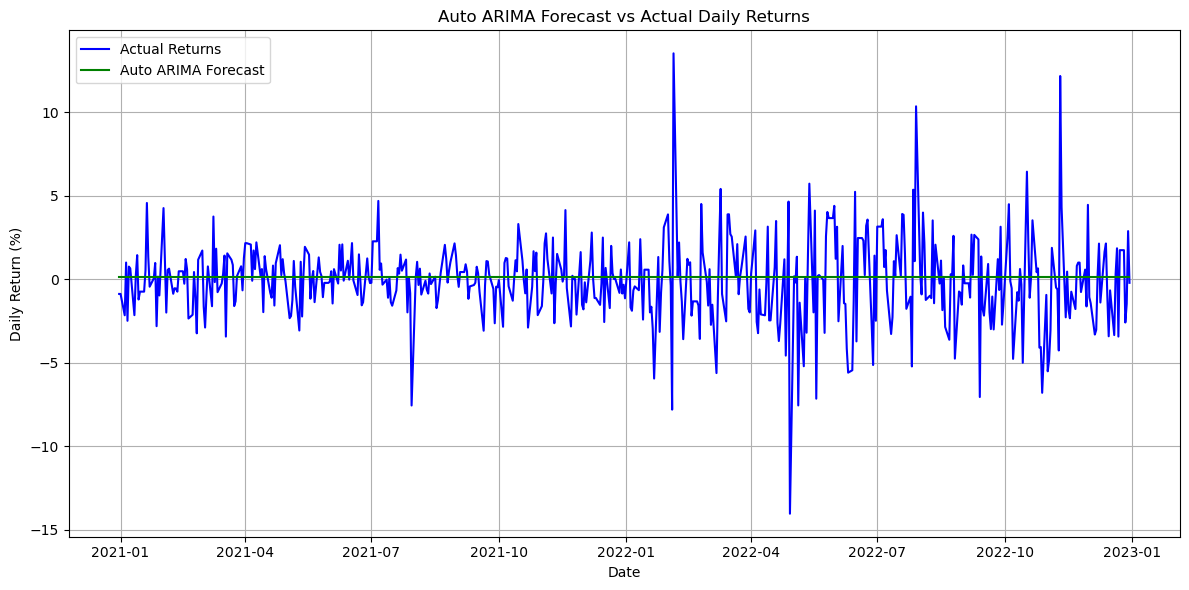

                         Model          AIC      RMSE    MAPE (%)  \
0  Auto ARIMA (seasonal tuned)  8632.735786  2.457825  120.924385   

  Order (p,d,q) Seasonal Order  
0     (0, 0, 0)   (0, 0, 0, 5)  
                               SARIMAX Results                                
Dep. Variable:                      y   No. Observations:                 2085
Model:                        SARIMAX   Log Likelihood               -4314.368
Date:                Sun, 04 May 2025   AIC                           8632.736
Time:                        06:31:16   BIC                           8644.021
Sample:                    01-03-2013   HQIC                          8636.871
                         - 12-30-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
inter

In [67]:
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import pmdarima as pm

# Step 3: Train-test split (80/20)
split_index = int(len(data) * 0.8)
train_data = data.iloc[:split_index]
test_data = data.iloc[split_index:]
train_returns = train_data['Return'].dropna()  # <== Drop NaNs explicitly
test_returns = test_data['Return']



# Step 3: Auto ARIMA with seasonality (weekly seasonality ~ 5 trading days)
model_auto = pm.auto_arima(
    train_returns,
    start_p=0, start_q=0,
    max_p=5, max_q=5,
    d=None,           # Let it test for unit root
    seasonal=True,
    start_P=0, start_Q=0,
    max_P=2, max_Q=2,
    D=None,           # Let it test seasonal differencing
    m=5,              # Weekly seasonality (5 trading days)
    test='adf',       # ADF test for stationarity
    seasonal_test='ocsb',
    trace=True,
    error_action='ignore',
    suppress_warnings=True,
    stepwise=True,
    n_fits=50
)


# Step 4: Forecast
n_periods = len(test_returns)
preds_arima = model_auto.predict(n_periods=n_periods)

# Step 5: Evaluation
rmse = np.sqrt(mean_squared_error(test_returns, preds_arima))
mape = mean_absolute_percentage_error(test_returns, preds_arima) * 100

# Step 6: Plot
plt.figure(figsize=(12, 6))
plt.plot(test_data.index, test_returns.values, label='Actual Returns', color='blue')
plt.plot(test_data.index, preds_arima, label='Auto ARIMA Forecast', color='green')
plt.title('Auto ARIMA Forecast vs Actual Daily Returns')
plt.xlabel('Date')
plt.ylabel('Daily Return (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 7: Results table
results_arima = pd.DataFrame({
    'Model': ['Auto ARIMA (seasonal tuned)'],
    'AIC': [model_auto.aic()],
    'RMSE': [rmse],
    'MAPE (%)': [mape],
    'Order (p,d,q)': [model_auto.order],
    'Seasonal Order': [model_auto.seasonal_order]
})

print(results_arima)
print(model_auto.summary())


**Model Fit Metrics**
| Metric        | Value   | Interpretation                                                                               |
| ------------- | ------- | -------------------------------------------------------------------------------------------- |
| **AIC**       | 8632.74 | Akaike Information Criterion – lower is better. Still quite high, suggesting poor model fit. |
| **RMSE**      | 2.46    | Root Mean Squared Error – indicates forecast error magnitude.                                |
| **MAPE**      | 120.92% | Mean Absolute Percentage Error – very high due to returns close to zero.                     |
| **Intercept** | 0.137   | The model predicts a constant average daily return of \~0.14%.                               |

**Model Diagnostics:**
| Test                       | Result              | Meaning                                                 |
| -------------------------- | ------------------- | ------------------------------------------------------- |
| **Ljung-Box Q (lag=1)**    | 0.21 (p = 0.65)     | No evidence of autocorrelation in residuals (good).     |
| **Jarque-Bera (JB)**       | 4602.60 (p < 0.001) | Strong non-normality in residuals (bad).                |
| **Skewness**               | 0.37                | Slight right skew in returns.                           |
| **Kurtosis**               | 10.24               | Heavy tails – much higher than Gaussian (kurtosis = 3). |
| **Heteroskedasticity (H)** | 1.12 (p = 0.12)     | Slight time-varying variance; not significant.          |



### **2. GARCH (Generalized Autoregressive Conditional Heteroskedasticity)**

**Model Purpose:**
Forecasts **volatility**, rather than returns. Suitable for financial time series with volatility clustering (periods of high/low variance).

**Model Notation:**
GARCH(p, q), where:

* **p** = number of lagged variances (GARCH terms)
* **q** = number of lagged squared residuals (ARCH terms)

**Model Form:**

$$
r_t = \sigma_t \varepsilon_t, \quad \varepsilon_t \sim N(0, 1)
$$

$$
\sigma_t^2 = \alpha_0 + \sum_{i=1}^q \alpha_i r_{t-i}^2 + \sum_{j=1}^p \beta_j \sigma_{t-j}^2
$$

**Key Feature:**
Captures time-varying volatility (conditional heteroskedasticity) in returns.

**Assumptions:**

* Returns have time-varying volatility
* Residuals are serially uncorrelated, but dependent via their variances

GARCH(1,1) with AR(1) mean — RMSE: 2.4614, MAPE: 135.93%


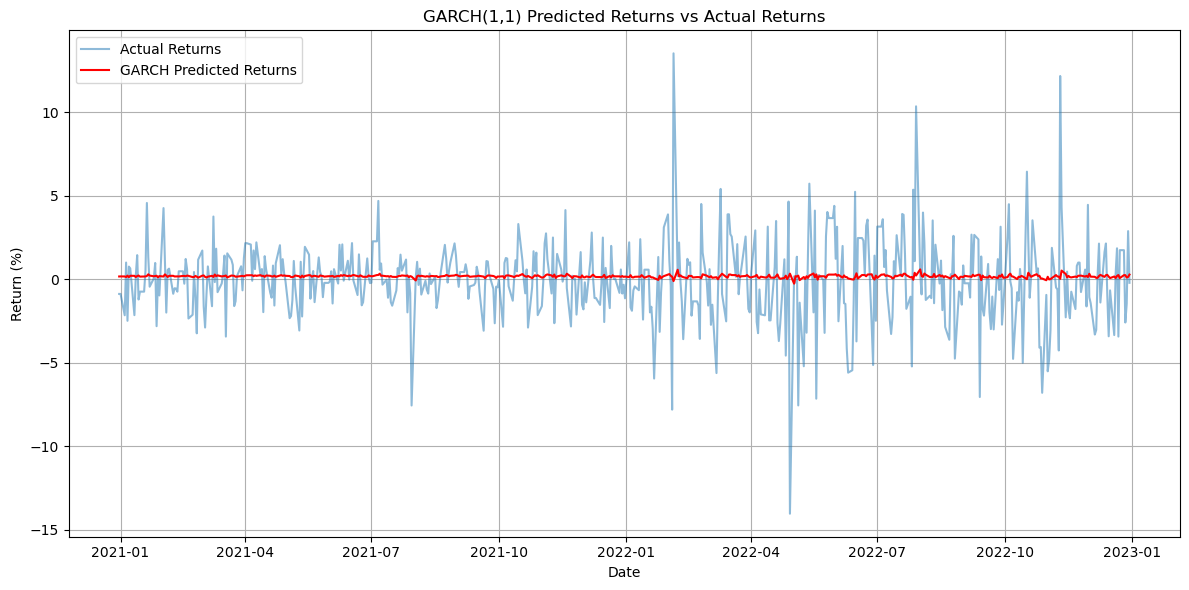

,Model,RMSE,MAPE (%)
0,"GARCH(1,1) AR(1)",2.461424,135.932835


In [43]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from arch import arch_model
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import warnings
warnings.filterwarnings('ignore')

# Ensure your `data` and test/train split is ready
returns_all = data['Return'].dropna()
returns_array = returns_all.values

# Define window sizes
train_size = int(len(returns_array) * 0.8)
train_returns = returns_array[:train_size]
test_returns = returns_array[train_size:]
test_index = data.index[-len(test_returns):]

# Initialize list to store 1-step-ahead forecasts
rolling_preds = []

# Rolling window GARCH(1,1) with AR(1) mean
for i in range(len(test_returns)):
    rolling_window = returns_array[i:train_size + i]
    model = arch_model(rolling_window, vol='GARCH', p=1, q=1, mean='AR', lags=1, dist='normal')
    result = model.fit(disp='off')
    forecast = result.forecast(horizon=1)
    predicted = forecast.mean.values[-1, 0]
    rolling_preds.append(predicted)

# Convert to array
predicted_return_garch = np.array(rolling_preds)

# Evaluation
rmse = np.sqrt(mean_squared_error(test_returns, predicted_return_garch))
mape = mean_absolute_percentage_error(test_returns, predicted_return_garch) * 100
print(f"GARCH(1,1) with AR(1) mean — RMSE: {rmse:.4f}, MAPE: {mape:.2f}%")

# Plot Actual vs Predicted Returns
plt.figure(figsize=(12, 6))
plt.plot(test_index, test_returns, label='Actual Returns', alpha=0.5)
plt.plot(test_index, predicted_return_garch, label='GARCH Predicted Returns', color='red')
plt.title('GARCH(1,1) Predicted Returns vs Actual Returns')
plt.xlabel('Date')
plt.ylabel('Return (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Optional: Store results for ensemble
results_garch = pd.DataFrame({
    'Model': ['GARCH(1,1) AR(1)'],
    'RMSE': [rmse],
    'MAPE (%)': [mape]
})
results_garch


In practice, we might predict volatility or use GARCH errors to adjust ARIMA forecasts. GARCH is widely used to model **non-constant volatility** in financial series.
### **3. Prophet (Additive Model with Nonlinear Trends)**

**Model Purpose:**
Captures complex seasonality (weekly, yearly), holidays, and trend changes. Designed for business and economic time series with structural breaks or irregular patterns.

**Model Form:**

$$
y(t) = g(t) + s(t) + h(t) + \varepsilon_t
$$

Where:

* $g(t)$: piecewise linear or logistic growth trend
* $s(t)$: seasonal components (Fourier series)
* $h(t)$: effects of holidays or events
* $\varepsilon_t$: error term (assumed Gaussian)

**Key Features:**

* Automatic changepoint detection
* Built-in weekly and yearly seasonality
* Robust to missing data and outliers

**Assumptions:**

* Additive components
* Seasonality is stable over time

06:26:33 - cmdstanpy - INFO - Chain [1] start processing
06:26:33 - cmdstanpy - INFO - Chain [1] done processing


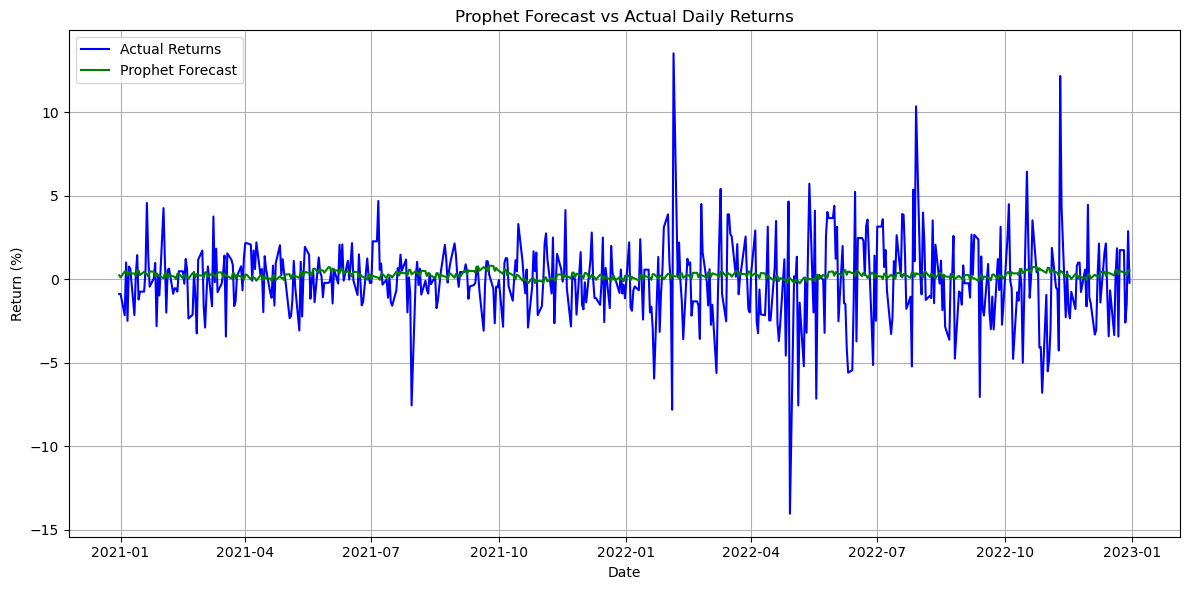

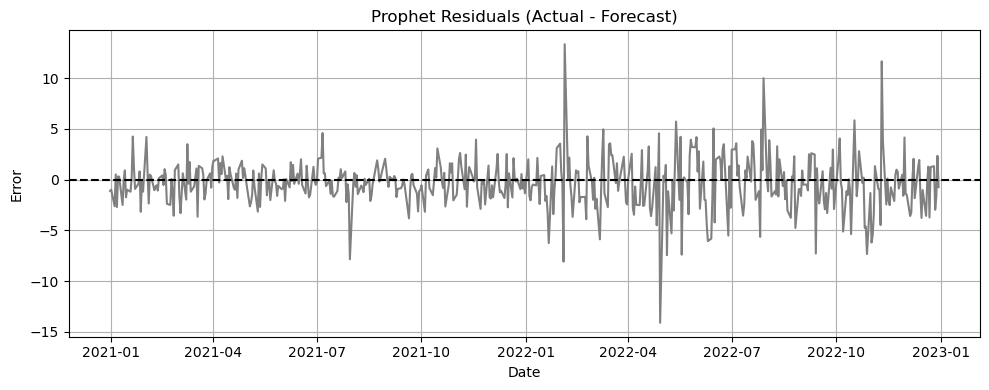

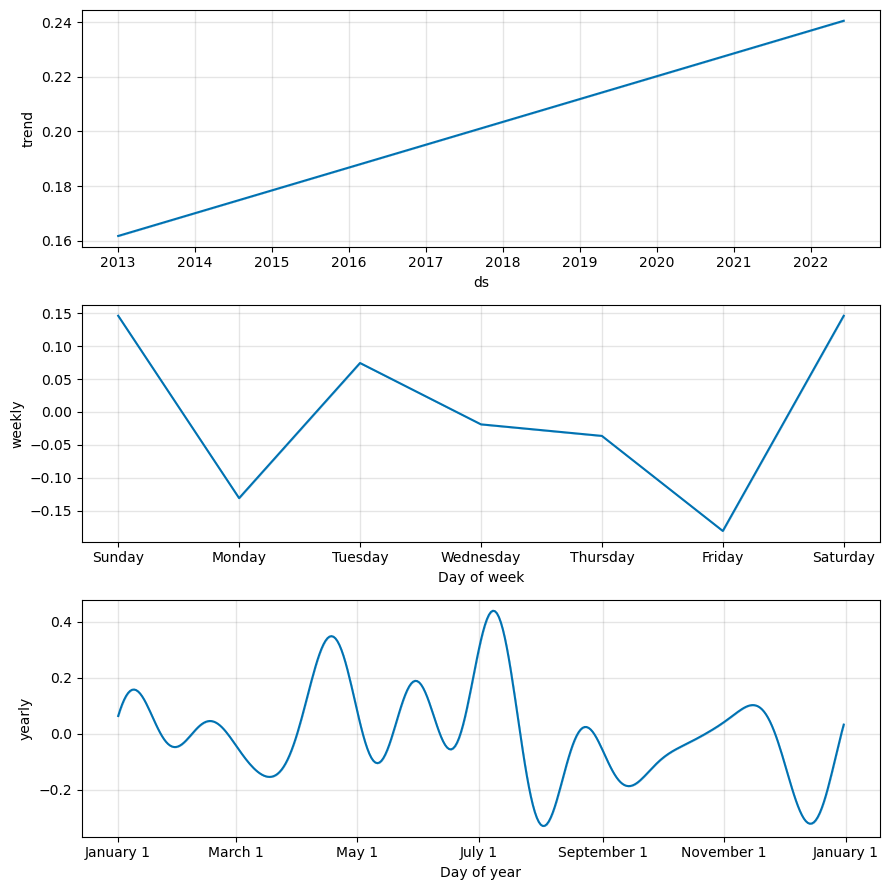

                       Model     RMSE    MAPE (%)
0  Prophet (weekly + yearly)  2.47575  145.301053


In [47]:
from prophet import Prophet
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Step 1: Format data for Prophet
df_prophet = train_data.reset_index()[['Date','Return']].rename(columns={'Date':'ds','Return':'y'})

# Step 2: Fit model with yearly and weekly seasonality
model_prophet = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
model_prophet.fit(df_prophet)

# Step 3: Create future dates and forecast
future = model_prophet.make_future_dataframe(periods=len(test_data))
forecast = model_prophet.predict(future)

# Step 4: Extract predicted returns for test period
preds_prophet = forecast['yhat'][-len(test_data):].values
test_dates = test_data.index
actual_returns = test_data['Return'].values

# Step 5: Evaluate
rmse = np.sqrt(mean_squared_error(actual_returns, preds_prophet))
mape = mean_absolute_percentage_error(actual_returns, preds_prophet) * 100

# Step 6: Plot forecast vs actual
plt.figure(figsize=(12, 6))
plt.plot(test_dates, actual_returns, label='Actual Returns', color='blue')
plt.plot(test_dates, preds_prophet, label='Prophet Forecast', color='green')
plt.title('Prophet Forecast vs Actual Daily Returns')
plt.xlabel('Date')
plt.ylabel('Return (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 7: Residual plot
residuals = actual_returns - preds_prophet
plt.figure(figsize=(10, 4))
plt.plot(test_dates, residuals, label='Residuals', color='gray')
plt.axhline(0, color='black', linestyle='--')
plt.title('Prophet Residuals (Actual - Forecast)')
plt.xlabel('Date')
plt.ylabel('Error')
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 8: Forecast components
model_prophet.plot_components(forecast)
plt.tight_layout()
plt.show()

# Step 9: Summary results table
results_prophet = pd.DataFrame({
    'Model': ['Prophet (weekly + yearly)'],
    'RMSE': [rmse],
    'MAPE (%)': [mape]
})
print(results_prophet)


  Prophet is robust and automatically handles trends and periodicity, which can be useful if the return series has seasonal patterns.
### **3. LSTM (Long Short-Term Memory Networks)**

**Model Purpose:**
A type of recurrent neural network (RNN) capable of learning long-term dependencies in sequential data. Useful for non-linear, non-stationary time series.

**Model Mechanics:**
LSTM cells maintain and update a **memory cell** using:

* **Forget gate**: Decides what information to discard
* **Input gate**: Decides what new information to store
* **Output gate**: Decides what to output

**Formally:**
Let $x_t$ be the input at time $t$, then:

$$
f_t = \sigma(W_f x_t + U_f h_{t-1} + b_f) \quad \text{(forget gate)}  
$$

$$
i_t = \sigma(W_i x_t + U_i h_{t-1} + b_i) \quad \text{(input gate)}  
$$

$$
o_t = \sigma(W_o x_t + U_o h_{t-1} + b_o) \quad \text{(output gate)}  
$$

$$
\tilde{c}_t = \tanh(W_c x_t + U_c h_{t-1} + b_c) \quad \text{(candidate memory)}  
$$

$$
c_t = f_t \cdot c_{t-1} + i_t \cdot \tilde{c}_t  
$$

$$
h_t = o_t \cdot \tanh(c_t)
$$

**Assumptions:**

* No assumption of stationarity
* Captures nonlinearity and complex temporal patterns

17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 


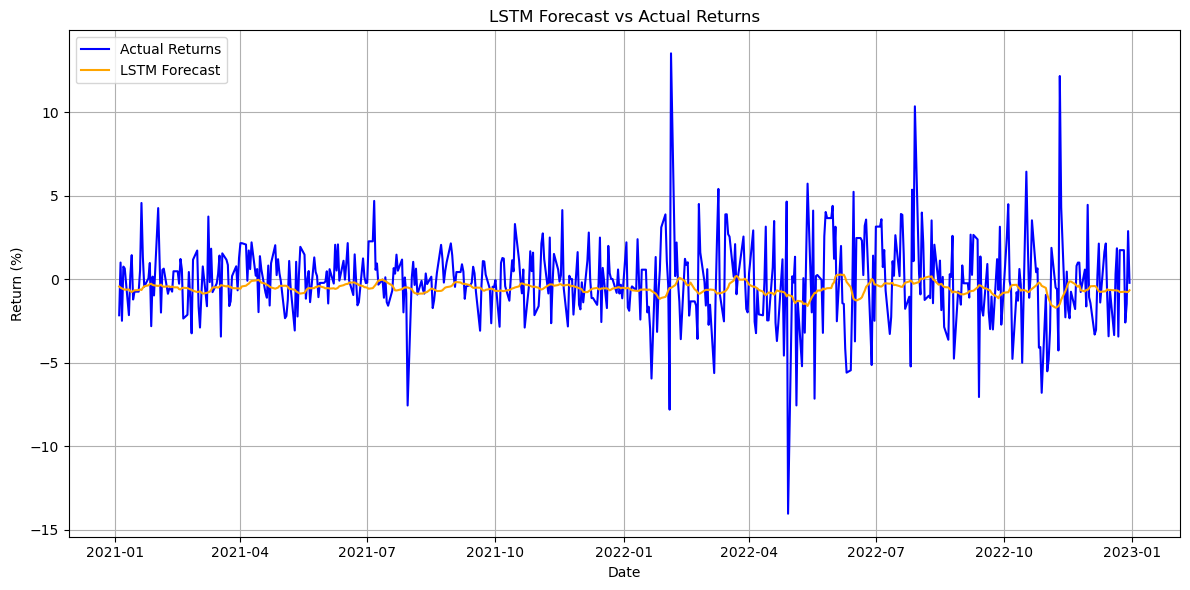

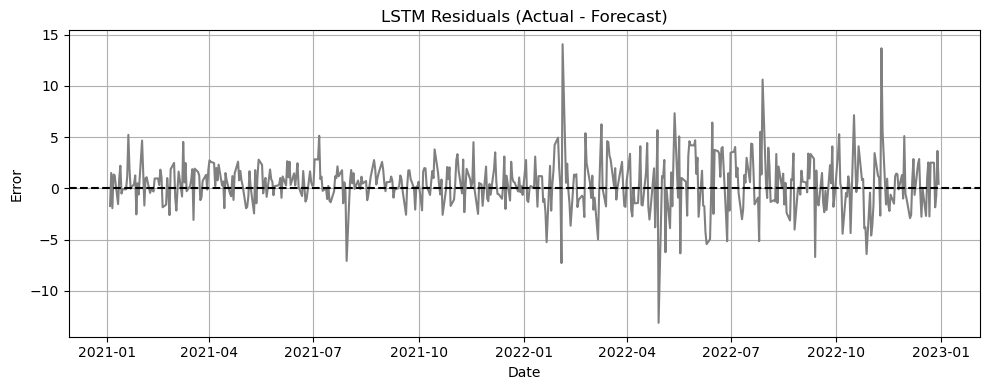

            Model      RMSE    MAPE (%)
0  LSTM (Returns)  2.525591  217.871672


In [52]:
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_percentage_error
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

# Step 1: Prepare the return series
returns = data['Return'].dropna().values.reshape(-1, 1)

# Step 2: Normalize returns
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_returns = scaler.fit_transform(returns)

# Step 3: Create lagged sequences
def create_sequences(data, n_steps):
    X, y = [], []
    for i in range(n_steps, len(data)):
        X.append(data[i-n_steps:i])
        y.append(data[i])
    return np.array(X), np.array(y)

n_steps = 10
X_all, y_all = create_sequences(scaled_returns, n_steps)

# Step 4: Split into train/test
split_index = int(0.8 * len(X_all))
X_train, X_test = X_all[:split_index], X_all[split_index:]
y_train, y_test = y_all[:split_index], y_all[split_index:]

# Step 5: Build and train LSTM
model_lstm = Sequential()
model_lstm.add(LSTM(50, input_shape=(n_steps, 1)))
model_lstm.add(Dense(1))
model_lstm.compile(optimizer='adam', loss='mse')
model_lstm.fit(X_train, y_train, epochs=20, batch_size=32, verbose=0)

# Step 6: Predict and inverse scale
preds_lstm_scaled = model_lstm.predict(X_test).flatten()
preds_lstm = scaler.inverse_transform(preds_lstm_scaled.reshape(-1, 1)).flatten()
y_test_true = scaler.inverse_transform(y_test.reshape(-1, 1)).flatten()

# Step 7: Evaluation
rmse = np.sqrt(mean_squared_error(y_test_true, preds_lstm))
mape = mean_absolute_percentage_error(y_test_true, preds_lstm) * 100

# Step 8: Plot actual vs predicted
test_dates = data.index[-len(y_test_true):]
plt.figure(figsize=(12, 6))
plt.plot(test_dates, y_test_true, label='Actual Returns', color='blue')
plt.plot(test_dates, preds_lstm, label='LSTM Forecast', color='orange')
plt.title('LSTM Forecast vs Actual Returns')
plt.xlabel('Date')
plt.ylabel('Return (%)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 9: Residual plot
residuals = y_test_true - preds_lstm
plt.figure(figsize=(10, 4))
plt.plot(test_dates, residuals, color='gray')
plt.axhline(0, color='black', linestyle='--')
plt.title('LSTM Residuals (Actual - Forecast)')
plt.xlabel('Date')
plt.ylabel('Error')
plt.grid(True)
plt.tight_layout()
plt.show()

# Step 10: Results table
results_lstm = pd.DataFrame({
    'Model': ['LSTM (Returns)'],
    'RMSE': [rmse],
    'MAPE (%)': [mape]
})
print(results_lstm)


  Here, `X_train` is a 3D array of shape (samples, timesteps, features). LSTM networks have been shown to excel at capturing non-linear, irregular patterns in financial data.

## 6. Model Evaluation

We reserve the last 2 years of data as a test set. For each model, we generate one-step-ahead forecasts on this hold-out set. We then compute error metrics:

* **RMSE (Root Mean Squared Error):**
  $\text{RMSE} = \sqrt{\frac{1}{N}\sum (y_\text{true}-y_\text{pred})^2}$. RMSE has the same unit as returns and penalizes large errors heavily.
* **MAPE (Mean Absolute Percentage Error):**
  $\text{MAPE} = \frac{100\%}{N}\sum \left|\frac{y_\text{true}-y_\text{pred}}{y_\text{true}}\right|$. This gives error as a percentage, making it scale-independent (though it can be high if true values are near zero).

In [56]:
print(results_garch.columns)


Index(['Model', 'RMSE', 'MAPE (%)'], dtype='object')


In [100]:

# ARIMA model order and seasonal order from the results_arima DataFrame
order_arima = results_arima['Order (p,d,q)'].iloc[0]
seasonal_order_arima = results_arima['Seasonal Order'].iloc[0]

# GARCH model order
order_garch = garch_fit.model.volatility.p, garch_fit.model.volatility.q
model_name_garch = f"GARCH{order_garch} - Volatility Forecast"


# Construct model names dynamically
model_name_arima = f"ARIMA {order_arima}{seasonal_order_arima}"
model_name_garch = f"GARCH{order_garch} - Volatility Forecast"

# Output the dynamically constructed model names
model_name_arima, model_name_garch

# Use variable values only, no hardcoded numbers
combined_results_clean = pd.DataFrame({
    'Model': [
        results_lstm['Model'].iloc[0],
        results_prophet['Model'].iloc[0],
        model_name_arima,
        model_name_garch
    ],
    'RMSE': [
        results_lstm['RMSE'].iloc[0],
        results_prophet['RMSE'].iloc[0],
        results_arima['RMSE'].iloc[0],
        results_garch['RMSE'].iloc[0]  # ✅ Now matches actual column
    ],
    'MAPE (%)': [
        results_lstm['MAPE (%)'].iloc[0],
        results_prophet['MAPE (%)'].iloc[0],
        results_arima['MAPE (%)'].iloc[0],
        results_garch['MAPE (%)'].iloc[0]  # ✅ Matches actual column
    ]
})

from IPython.display import display
display(combined_results_clean)



,Model,RMSE,MAPE (%)
0,LSTM (Returns),2.525591,217.871672
1,Prophet (weekly + yearly),2.475750,145.301053
2,"ARIMA (0, 0, 0)(0, 0, 0, 5)",2.457825,120.924385
3,"GARCH(1, 1) - Volatility Forecast",2.461424,135.932835



## 7. Ensemble Model

To improve forecasts, we build an ensemble combining the individual models. One approach is **stacking**: use the predictions of the base models as inputs to a meta-learner. For example:

### Weighted Average Ensemble (Linear Weights)
**Idea:** Assign higher weights to better-performing models (e.g., based on inverse RMSE).

In [102]:
# Step 1: Collect model predictions and RMSEs
predictions = [
    preds_arima_trimmed,
    preds_prophet_trimmed,
    preds_lstm_trimmed,
    garch_signed_preds_trimmed
]

rmses = np.array([
    combined_results_clean.loc[combined_results_clean['Model'].str.contains("ARIMA"), 'RMSE'].values[0],
    combined_results_clean.loc[combined_results_clean['Model'].str.contains("Prophet"), 'RMSE'].values[0],
    combined_results_clean.loc[combined_results_clean['Model'].str.contains("LSTM"), 'RMSE'].values[0],
    combined_results_clean.loc[combined_results_clean['Model'].str.contains("GARCH"), 'RMSE'].values[0],
])

# Step 2: Inverse-RMSE weights
inv_rmse_weights = 1 / rmses
weights = inv_rmse_weights / inv_rmse_weights.sum()

# Step 3: Weighted average ensemble
ensemble_preds_weighted = np.average(predictions, axis=0, weights=weights)

# Step 4: Evaluation
ensemble_rmse_weighted = np.sqrt(mean_squared_error(actual_returns_trimmed, ensemble_preds_weighted))
ensemble_mape_weighted = mean_absolute_percentage_error(actual_returns_trimmed, ensemble_preds_weighted) * 100

# Step 5: Add to table
ensemble_weighted_results = pd.DataFrame({
    'Model': ['Weighted Ensemble (Inverse RMSE)'],
    'RMSE': [ensemble_rmse_weighted],
    'MAPE (%)': [ensemble_mape_weighted]
})
combined_results_clean = pd.concat([combined_results_clean, ensemble_weighted_results], ignore_index=True)
display(combined_results_clean)


,Model,RMSE,MAPE (%)
0,LSTM (Returns),2.525591,217.871672
1,Prophet (weekly + yearly),2.475750,145.301053
2,"ARIMA (0, 0, 0)(0, 0, 0, 5)",2.457825,120.924385
3,"GARCH(1, 1) - Volatility Forecast",2.461424,135.932835
4,Weighted Ensemble (Inverse RMSE),2.457562,105.811544


### Stacking Ensemble (Meta-Learner)
**Idea:** Train a meta-model (e.g., linear regression or XGBoost) on predictions of the base models.

In [106]:
from sklearn.linear_model import LinearRegression

# Step 1: Prepare input matrix for meta-model
X_stack = np.vstack([
    preds_arima_trimmed,
    preds_prophet_trimmed,
    preds_lstm_trimmed,
    garch_signed_preds_trimmed
]).T  # shape: (n_samples, n_models)

y_stack = actual_returns_trimmed

# Step 2: Fit meta-model
meta_model = LinearRegression()
meta_model.fit(X_stack, y_stack)

# Step 3: Predict
ensemble_preds_stacking = meta_model.predict(X_stack)

# Step 4: Evaluate
ensemble_rmse_stack = np.sqrt(mean_squared_error(y_stack, ensemble_preds_stacking))
ensemble_mape_stack = mean_absolute_percentage_error(y_stack, ensemble_preds_stacking) * 100

# Step 5: Add to results
ensemble_stacking_results = pd.DataFrame({
    'Model': ['Stacked Ensemble (Linear Regression)'],
    'RMSE': [ensemble_rmse_stack],
    'MAPE (%)': [ensemble_mape_stack]
})
combined_results_clean = pd.concat([combined_results_clean, ensemble_stacking_results], ignore_index=True)
display(combined_results_clean)

,Model,RMSE,MAPE (%)
0,LSTM (Returns),2.525591,217.871672
1,Prophet (weekly + yearly),2.475750,145.301053
2,"ARIMA (0, 0, 0)(0, 0, 0, 5)",2.457825,120.924385
3,"GARCH(1, 1) - Volatility Forecast",2.461424,135.932835
4,Weighted Ensemble (Inverse RMSE),2.457562,105.811544
5,Stacked Ensemble (Linear Regression),2.450775,111.846398


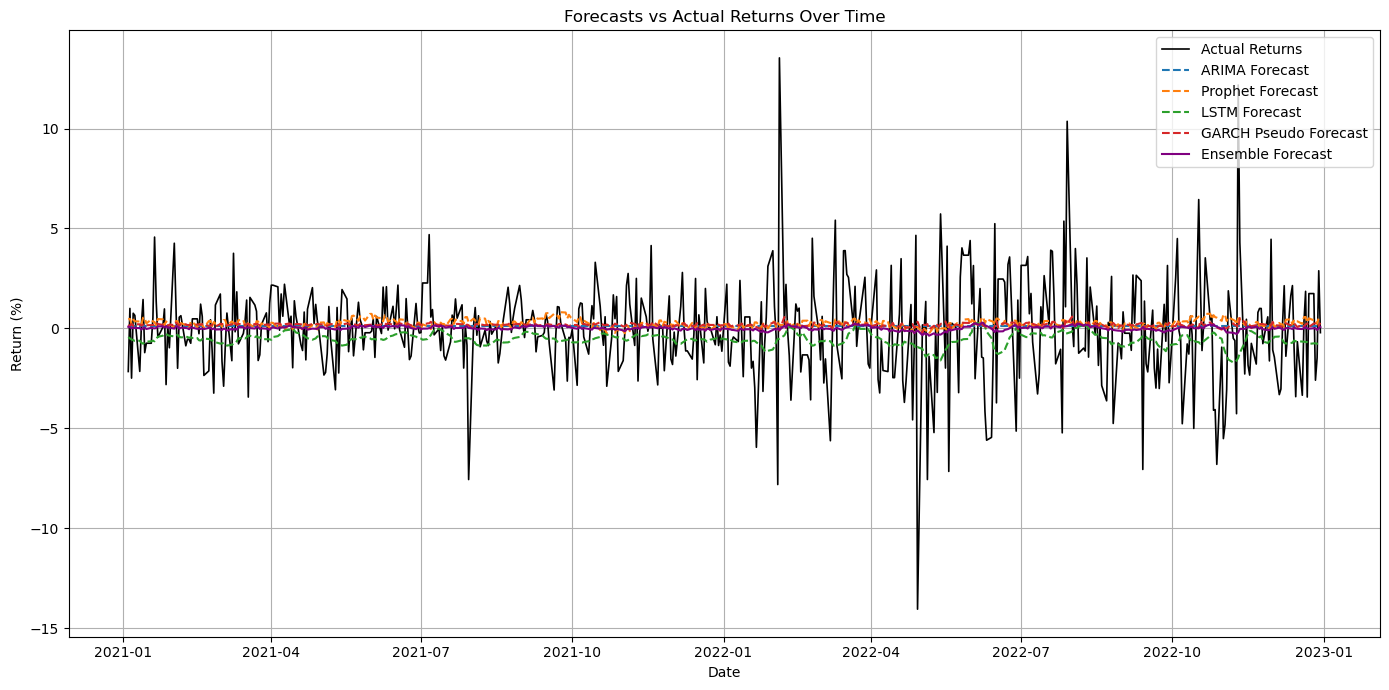

In [79]:
actual_returns = test_data['Return'].values

# Ensure all series are trimmed and aligned using the last `min_len` timestamps
min_len = min(
    len(preds_arima),
    len(preds_prophet),
    len(preds_lstm),
    len(predicted_return_garch),
    len(ensemble_preds_mean_all),
    len(actual_returns)
)

# Use the last min_len dates from test_data index
aligned_dates = test_data.index[-min_len:]

# Truncate all series
preds_arima_trimmed = preds_arima[-min_len:]
preds_prophet_trimmed = preds_prophet[-min_len:]
preds_lstm_trimmed = preds_lstm[-min_len:]
garch_signed_preds_trimmed = predicted_return_garch[-min_len:]
ensemble_preds_trimmed = ensemble_preds_mean_all[-min_len:]
actual_returns_trimmed = actual_returns[-min_len:]

# Plot all time series
plt.figure(figsize=(14, 7))
plt.plot(aligned_dates, actual_returns_trimmed, label='Actual Returns', color='black', linewidth=1.2)
plt.plot(aligned_dates, preds_arima_trimmed, label='ARIMA Forecast', linestyle='--')
plt.plot(aligned_dates, preds_prophet_trimmed, label='Prophet Forecast', linestyle='--')
plt.plot(aligned_dates, preds_lstm_trimmed, label='LSTM Forecast', linestyle='--')
plt.plot(aligned_dates, garch_signed_preds_trimmed, label='GARCH Pseudo Forecast', linestyle='--')
plt.plot(aligned_dates, ensemble_preds_trimmed, label='Ensemble Forecast', color='purple', linewidth=1.5)
plt.title('Forecasts vs Actual Returns Over Time')
plt.xlabel('Date')
plt.ylabel('Return (%)')
plt.legend(loc='upper right')
plt.grid(True)
plt.tight_layout()
plt.show()
